In [53]:
import os
import re
import json
import pickle

import gensim
from gensim import models
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
mpl.rcParams['figure.dpi']= 160

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

## Files loading

In [54]:
# GRAPES
with open('knowledge/grapes.json') as json_data:
    grapes = json.load(json_data)
    json_data.close()
    grapes = grapes['grapes']

grapes = [i.lower() for i in grapes]
gr = [" " + grape + " " for grape in grapes]

# WINE KIND
with open('knowledge/kind.json') as json_data:
    kind = json.load(json_data)
    json_data.close()
    kind = kind['kind']

kind = [i.lower() for i in kind]
kind = [" " + i.lower()+" " for i in kind]

# ITA NAMES
with open('knowledge/appellations-it.json') as json_data:
    winename = json.load(json_data)
    json_data.close()
    winename = winename['appellations']

winename = [i.lower() for i in winename]

# USA NAMES
winename_usa_tmp = pd.read_csv('knowledge/appellations-usa.csv')
winename_usa_tmp.iloc[:,0] = winename_usa_tmp.iloc[:,0] .map(lambda x: x.replace(' AVA',''))

winename_usa = list(winename_usa_tmp.iloc[:,0])
winename_usa = [x.lower() for x in winename_usa]

# AROMAS
with open("knowledge/list_aromas.txt", "rb") as fp:
    aromas = pickle.load(fp)
    
# OCRS
ocrs_dict = {}
with open('saved_things/ocrs_dictionary_improved.json' ) as json_data:
    ocrs_dict = json.load(json_data)
    json_data.close()
jsons = ocrs_dict

###  Terms

In [55]:
Bitter_Red = "Chewy, Muscular, Structured, Firm, Rigid, Closed, Dried Herbs, Oregano, Bay Leaf, Bitter Chocolate, Baker’s Chocolate, Bitter Herbs, Austere, Angular, Grippy, Harsh, Coarse, Dense".lower().split(", ")
Bitter_White = "Austere, Citrus Pith, Quince, Bitter Almond, Green Mango, Green Almond, Chalk".lower().split(", ")

Light_Bodied_Red = "Subtle, Delicate, Elegant, Crisp, Thin, Finesse, Bright, Floral".lower().split(", ")
Light_Bodied_White = "Light, Zesty, Airy, Lean, Racy, Crisp, Zippy, Austere, Long Tingly Finish, Brilliant, Lively".lower().split(", ")

Savory_Red = "Cranberry, Rhubarb, Black Currant (aka Cassis), Green Bell Pepper, Green Peppercorn, Olive, Wild Strawberry, Sour Cherry, Mulberry, Bilberry, Peony, Wild Blueberry, Dried Herbs, Game, Sage, Leather, Tobacco, Charcoal, Tar, Underbrush, Garrigue, Gravel, Torrefaction, Mineral-Driven and Woodsmoke".lower().split(", ") 
Savory_White = "Lime, Lemon, Pith, Quince, Bitter Almond, Green Apple, Apple Skin, Gooseberry, Jalapeño, Grapefruit, Green Papaya, Thyme, Chervil, Grass, Flint, Chalk, Petrichor, Minerally".lower().split(", ")

Fruit_Forward_Red = "Sweet Raspberry, Maraschino Cherry, Blackberry, Blueberry, Jam, Prune, Candied Fruit, Black Raisin, Baking Spices, Toffee, Vanilla and Sweet Tobacco".lower().split(", ")
Fruit_Forward_White = "Sweet Meyer Lemon, Baked Apple, Mandarin Orange, Ripe Peach, Mango, Sweet Pineapple, Ripe Pear, Cantaloupe, Crème Brûlée, Caramel, and Vanilla".lower().split(", ")

fruit = ["honey", "fruit", "strawberry", "raspberry", "apple", "citrus", "vanilla", "pineapple", "pear", "mint", "plum", "blackberry", "cherry", "melon", "peach", "peaches", "lemon", "lime"]

others = ['cream', 'starfruit', 'Passion Fruit', 'guava', 'ginger', 'sediment', 'cinnamon', 'apricot', 'chocolate', 'sparkling', 'coffee', 'cherries', 'crème', 'fruity', 'brulee' ,'savory', 'berries', 'sweet', 'buttery', 'berry', 'mocha', 'lime', 'fresh', 'dry', 'grapefruit', 'juicy', 'acidity', 'spicy', 'silky', 'mango', 'guava', 'smooth', 'papaya', 'oily', 'marzipan', 'jasmine', 'pomelo', 'hazelnut', 'chamomile', 'butter', 'rose', 'violet', 'potpourri', 'creamy', 'anise', 'orange', 'refreshing', 'tangerine', 'pepper', 'caramel', 'acacia', 'daffodil', 'minerals', 'banana']

food = ['meat', 'cheese', 'fish']

important_words = Fruit_Forward_Red + Fruit_Forward_White + Savory_Red + Savory_White + \
Bitter_White + Bitter_Red +  kind + food + Light_Bodied_Red + Light_Bodied_White +  fruit + others \
+ ['tannins', 'bold']

len(important_words)

202

## Gensim model for clustering

In [56]:
data = []
for key, value in jsons.items():
    data.append(simple_preprocess(value))
    
#print(len(jsons))
print(len(data))

522


In [57]:
jsons['4']

'CELEBRE ROSE IS A METHODE CHAMPENOISE\nSPARKLING WINE MADE FROM PINOT MEUNIER.\n\nDR. KONSTANTIN FRANK, WAS THE FIRST TO PIONEER\nQUALITY VINIFERA IN THE EASTERN UNITED STATES.\nFOR OVER FIFTY-FIVE YEARS, THE WINERY HAS BEEN\nAMONG THE MOST PRESTIGIOUS IN THE FINGER LAKES\nWINE REGION OF NEW YORK STATE. OUR STORY IS\nA LEGACY FOUR GENERATIONS IN THE MAKING.\n\nPRODUCED & BOTTLED BY\nCHATEAU FRANK INC. HAMMONDSPORT, N.Y. 14840\n\nGOVERNMENT WARNING: (1) ACCORDING TO THE SURGEON\nGENERAL, WOMEN SHOULD NOT DRINK ALCOHOLIC BEVERAGES\nDURING PREGNANCY BECAUSE OF THE RISK OF BIRTH DEFECTS.\n(2) CONSUMPTION OF ALCOHOLIC BEVERAGES IMPAIRS YOUR\nABILITY TO DRIVE A CAR OR\n\nOPERATE MACHINERY, AND\n\nMAY CAUSE HEALTH PROBLEMS.\n\n12% ALC. VOL.750ML\nCONTAINS SULFITES'

**Word embedding** model:<br>
Word embedding is a representation of words in a vector space where words vectors are near if two words occurr in the same linguistic context (are semantically similar).<br>

So we map words to integer numbers vectors

In [59]:
model = models.Word2Vec(
    data,
    hs=1,          # If 1, hierarchical softmax will be used for model training.
    size=5,        # Dimensionality of the word vectors.
    window=3,      # Maximum distance between the current and predicted word within a sentence.
    min_count=2,   # Ignores all words with total frequency lower than this.
    workers=10)    # Worker threads to train the model

model.train(data, total_examples=len(data), epochs=50)

(2089225, 3069900)

In [62]:
X = model[model.wv.vocab] #len(model.wv.vocab) 1605

X[0]

/home/nicole/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.2553253,  0.6523723,  0.6680453,  2.969009 ,  0.8557398],
      dtype=float32)

In [67]:
model.wv.vocab['wine'].count

650

In [68]:
# create a dictionary associating words to integers

w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count
    
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
w2cSortedList = list(w2cSorted.keys())

# creating a list of words
list_of_words = []
for key, value in w2c.items():
    list_of_words.append(key)

## Clustering

In [69]:
import scipy.cluster.hierarchy as shc
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA

import numpy as np

In [70]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [71]:
def display_clusters(words_array, kmeans):
    
    """Function to plot 2D points and check clusters"""
    
    word_labels = words_array[:, 0]
    x_coords = np.array(words_array[:, 1]).astype(np.float)
    y_coords = np.array(words_array[:, 2]).astype(np.float)

    tot_col = {0:'blue', 1:'red',  5:'yellow', 2:'green', 3:'orange', 4:'black', 6:'purple'}
    # display scatter plot
    plt.scatter(x_coords, y_coords)
    lab = kmeans.labels_
    
    colors = {}
    for j in range(0,len(set(labels))):
        colors[j] = tot_col[j] 

    plt.scatter(x_coords, y_coords , c=list(map(lambda x: colors[x], lab)), s=5)
    #plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [72]:
pca = PCA(n_components=2)

# Feed PCA model with the word embedding made with Gensim (vector of length 5)
pca_model = pca.fit_transform(X) 

# choose a group of words that I want to clusterize: I try with the words of aromas ecc.
words_to_cluster = np.c_[np.array(list_of_words), pca_model]

list_idx_to_delete = []
for idx, row in enumerate(words_to_cluster):
    if (row[0] not in aromas):
        list_idx_to_delete.append(idx)
        
words_to_cluster = np.delete(words_to_cluster, list_idx_to_delete, axis=0)
len(words_to_cluster)

56

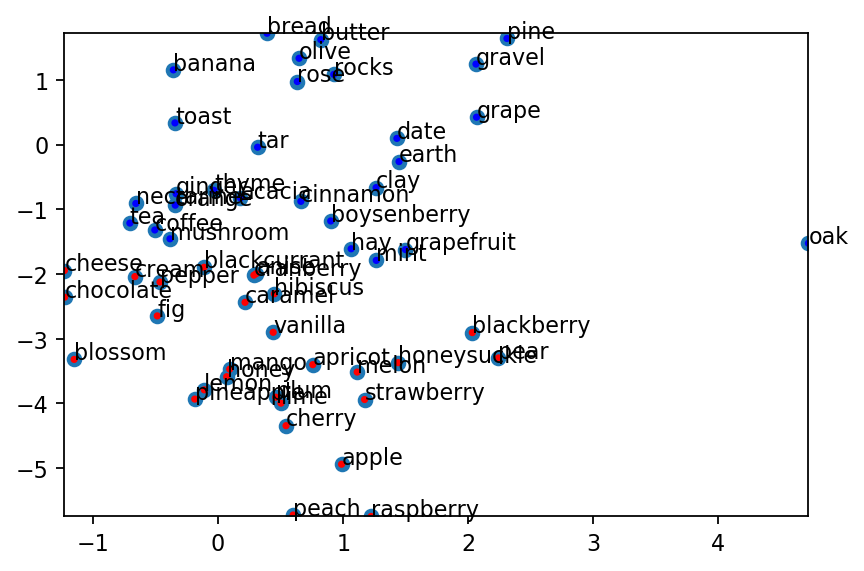

In [73]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(np.array(words_to_cluster[:,1:3]).astype(np.float))
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

new_data = []
for x in labels:
    a = lambda x: 'red' if x == 0 else 'blue'
    new_data.append(a(x))
    
words_labels_display = np.c_[words_to_cluster, labels]   

display_clusters(words_labels_display, kmeans)

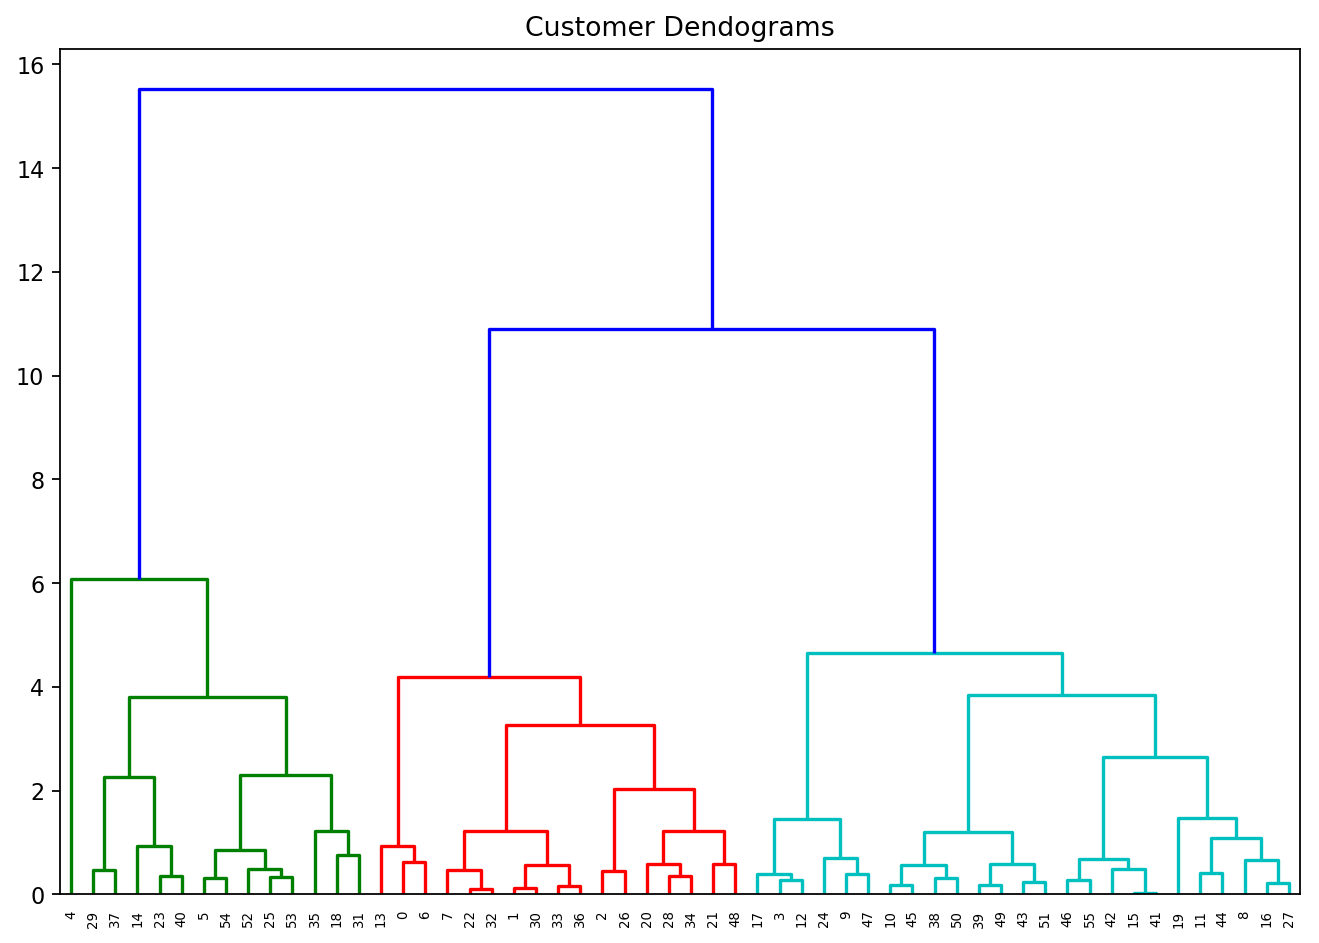

In [74]:
# DISPLAYING DENDOGRAM FOR CLUSTER

df = pd.DataFrame(words_labels_display)
data = df.iloc[:, 1:3].values  

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(data, method='ward'))  

Agglomerative Clustering

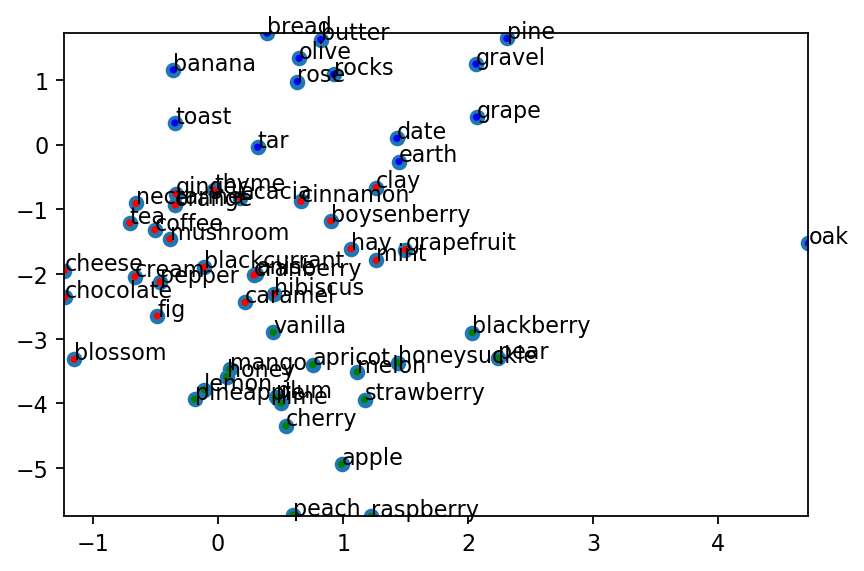

In [75]:
agglomclus = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agglomclus.fit_predict(np.array(words_to_cluster[:,1:3]).astype(np.float))  
labels = agglomclus.labels_

new_data = []
for x in labels:
    a = lambda x: 'red' if x == 0 else 'blue'
    new_data.append(a(x))
    
prova2 = np.c_[words_to_cluster, labels]   

display_clusters(words_labels_display, agglomclus)

## Getting bigrams and trigrams

In [15]:
bigram = models.Phrases(data, min_count=1, delimiter=b' ')
trigram = models.Phrases(bigram[data], min_count=1, delimiter=b' ')

trigram_sentences_project = []

for sent in data:
    bigrams_ = bigram[sent]
    trigrams_ = trigram[bigram[sent]]
    trigram_sentences_project.append(trigrams_)
    
trigram[[u'trees', u'new', u'york']]

['trees', 'new', 'york']

In [17]:
def get_bigrams(myString):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(myString)
    stemmer = PorterStemmer()
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 500)

    for bigram_tuple in bigrams:
        x = "%s %s" % bigram_tuple
        tokens.append(x)

    result = [' '.join([stemmer.stem(w).lower() for w in x.split()]) for x in tokens if x.lower() not in stopwords.words('english') and len(x) > 8]
    return result

for k, val in jsons.items():
    if (int(k) == 5):    
        #print(val)
        print(get_bigrams(val))

['sauvignon', 'luxuri', 'raspberri', 'govern', 'accord', 'alcohol', 'beverag', 'pregnanc', 'alcohol', 'beverag', 'machineri', '2013 cabernet', '6 govern', 'alcohol beverag', 'birth defect', 'bottl by', 'cabernet sauvignon', 'caus health', 'com grown', 'contain sulfit', 'counti luxuri', 'cabernet reveal', 'govern warn', 'health problem', 'i contain', 'impair your', 'luxuri layer', 'may caus', 'not drink', 'oper machineri', 'or oper', 'pleas recycl', 'pregnanc becaus', 'should not', 'ss pleas', 'surgeon gener', 'warn :', 'women should', 'your abil', 'black cherri', 'cinnamon spice', 'dark cocoa', 'deep note', 'estat grown', 'grill rib', 'grown cabernet', 'in velveti', 'lamb never', 'layer with', 'never had', 'or roast', 'our estat', 'reveal a', 'roast leg', 'spice wrap', 'thi good', 'velveti tannin', 'with deep', 'wrap in', 'your grill', ') accord', '0 sumption', 'abil to', 'accord to', 'and bottl', 'beverag dug', 'beverag impair', 'drink alcohol', 'famili wineri', 'famili wlm', 'produc 

In [18]:
# Set values for various parameters
num_features = 10    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


model = models.word2vec.Word2Vec(trigram_sentences_project, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

vocab = list(model.wv.vocab.keys())
print(vocab[:10])

['1.189829', '-5.15924', '0.22049649', '-3.0134685', '2.2192442', '-3.0995104', '1.4479154', '-1.5836147', '4.772393', '-1.2982551']
